In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
from collections import defaultdict
import datetime
import random

import arrow
import pandas as pd

# Let's simulate running korben-twitter both ways!

1. The first way uses a randomized sleep between 0 and 12 hrs
2. The second way uses a scheduled task on my Windows computer

In [166]:
# Params - generating for a whole year
start_time = arrow.get('2019-01-01')
end_time = arrow.get('2020-01-01')

# Init to no events (hit this cell if you want to refresh the sims!)
events = []

In [167]:
EVENT_NAMES = ['SLEEP', 'CRON', 'CLICK']

def sleep_event(t):
    events.append(('SLEEP', t.datetime))
    events.sort(key=lambda t: t[0])
    
def cron_event(t):
    events.append(('CRON', t.datetime))
    events.sort(key=lambda t: t[1])

def click_event(t):
    events.append(('CLICK', t.datetime))
    events.sort(key=lambda t: t[1])

In [168]:
def sleep_interval(max_hrs):
    # Math.floor(Math.random() * 12 * HOUR);
    return max_hrs * 60 * 60 * random.random()


def maybe_cron(t, laziness):
    if random.random() > laziness:
        cron_event(t)


def cron_fuzz(max_minutes):
    return random.random() * max_minutes


# Going to BOE simulate me turning off and on my Windows computer
# All of these values are hard-coded 🙂

days = defaultdict(dict)


BUSY_ON_WEEKEND_LIKELIHOOD = 0.2

def is_computer_on(dt):
    day = days[dt.date()]
    if not day:
        if dt.format('dddd', locale='en_US') in ('Saturday', 'Sunday'):
            day['wakeup_dt'] = arrow.get(dt.date()).shift(hours=11 + 3 * random.random())
            day['sleep_dt'] = arrow.get(dt.date()).shift(hours=23 + 3 * random.random())
            
            if random.random() > BUSY_ON_WEEKEND_LIKELIHOOD:
                day['leave_dt'] = day['wakeup_dt'].shift(hours=1 + 5 * random.random())
                day['arrive_dt'] = arrow.get(min([
                    day['sleep_dt'].shift(hours=-1).datetime,
                    day['leave_dt'].shift(hours=8 * random.random()).datetime
                ]))
        else:
            day['wakeup_dt'] = arrow.get(dt.date()).shift(hours=18.5 + 1 * random.random())
            day['sleep_dt'] = arrow.get(dt.date()).shift(days=1).shift(hours=1 * random.random())
            
    is_in_wake_interval = day['wakeup_dt'] <= dt.datetime < day['sleep_dt']
    
    if 'leave_dt' in day:
        is_in_leave_interval = day['leave_dt'] <= dt.datetime < day['arrive_dt']
    else:
        is_in_leave_interval = False
        
    return is_in_wake_interval and not is_in_leave_interval

In [169]:
MAX_SLEEP_HRS = 12

current_time = start_time

while current_time < end_time:
    sleep_event(current_time)
    current_time = current_time.shift(seconds=sleep_interval(MAX_SLEEP_HRS))
    

In [170]:
CRON_INTERVAL_HRS = 1
LAZINESS = 0.2
CRON_FUZZ_MIN = 30

tick_time = start_time

while tick_time < end_time:
    tick_time = tick_time.shift(hours=CRON_INTERVAL_HRS)
    exec_time = tick_time.shift(minutes=cron_fuzz(CRON_FUZZ_MIN))
    if is_computer_on(exec_time):
        maybe_cron(exec_time, LAZINESS)

In [171]:
# I don't click very often lol
CLICK_INTERVAL_SECS = 60 * 60

tick_time = start_time

while tick_time < end_time:
    tick_time = tick_time.shift(seconds=CLICK_INTERVAL_SECS)
    if is_computer_on(tick_time):
        click_event(tick_time)

In [172]:
df = pd.DataFrame(events, columns=['event_name', 'timestamp'])

In [173]:
df

,event_name,timestamp
0,SLEEP,2019-01-01 00:00:00+00:00
1,SLEEP,2019-01-01 05:51:10.110368+00:00
2,SLEEP,2019-01-01 12:37:37.980567+00:00
3,SLEEP,2019-01-01 17:08:06.398861+00:00
4,CLICK,2019-01-01 19:00:00+00:00
5,CRON,2019-01-01 19:16:40.374933+00:00
6,CLICK,2019-01-01 20:00:00+00:00
7,CRON,2019-01-01 20:02:09.274346+00:00
8,CLICK,2019-01-01 21:00:00+00:00
9,CRON,2019-01-01 21:11:52.578040+00:00


In [174]:
# Use this to generate plottable dataframes

def sample(bucket_size, start_dt=None, end_dt=None, event_cols=EVENT_NAMES):
    condition = start_dt.datetime <= df['timestamp'] if start_dt else None
    if condition is not None:
        condition = condition & (df['timestamp'] < end_dt.datetime)
    elif end_dt:
        condition = df['timestamp'] < end_dt.datetime
    
    by_dt = df if condition is None else df[condition]
    
    by_dt = by_dt.copy()
    
    for event_name in EVENT_NAMES:
        by_dt[event_name] = 1 * (by_dt['event_name'] == event_name)
        by_dt[event_name] = 1 * (by_dt['event_name'] == event_name)
    
    by_dt = by_dt[['timestamp'] + event_cols].copy()

    return by_dt.set_index(['timestamp']).resample(bucket_size).sum()

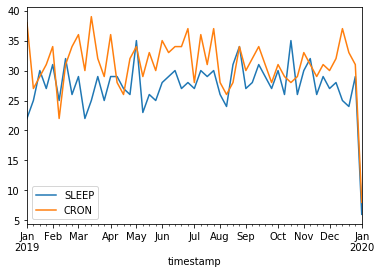

In [176]:
# Year-level bird's eye view - we can see that on a day by day basis
# frequency is similar
sample('W', event_cols=['SLEEP', 'CRON']).plot()

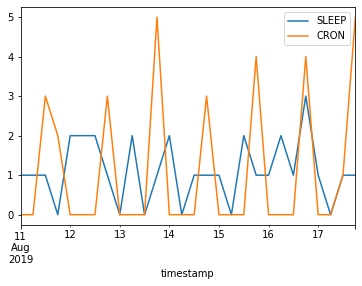

In [177]:
# A particular week on a 6-hour grain
# You can see that cron is spikier - this is expected
sample(datetime.timedelta(hours=6), arrow.get('2019-08-11'), arrow.get('2019-08-18'), event_cols=['SLEEP', 'CRON']).plot()

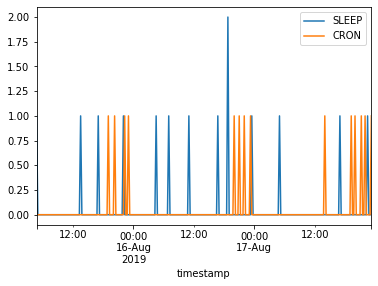

In [179]:
# A closer view of a 3 day window starting from today
# You can see the clustering of the specific events now
sample(
    datetime.timedelta(minutes=15),
    arrow.utcnow().replace(hour=0),
    arrow.utcnow().replace(hour=0).shift(days=3),
    event_cols=['SLEEP', 'CRON']
).plot()